In [1]:
# Import modules
import pandas as pd
import numpy as np
import preprocessor as p
import re, string
import nltk
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
from wordcloud   import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from pandas import DataFrame
from nltk.corpus import stopwords
from statistics import mean
from scipy import spatial
import matplotlib
import seaborn as sns

from collections import Counter

C:\Users\agapi\anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\agapi\anaconda\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
C:\Users\agapi\anaconda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\agapi\anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Read in data
data = pd.read_csv(r'Final_dataset.csv', encoding = 'latin')
data.rename(columns = {'full_text_2': 'text', 'data_created_at': "date"}, inplace = True)

In [3]:
print(data.shape)

(230899, 4)


In [4]:
data = data.reset_index(drop=True)

In [5]:
data

,created_at_last,text,user_id,country
0,1/29/2020,a shanghai resident infected with coronavirusr...,1.220000e+18,ä¸­å½
1,1/29/2020,the coronavirus is a threat to the global drug...,1.378637e+09,United States
2,1/28/2020,unsettling it suggests a dangerous politicisat...,1.220000e+18,Australia
3,1/31/2020,coronavirus overtakes sars via scmpgraphics ...,2.450444e+09,United States
4,1/25/2020,coronavirus more feedback from wuhan medical s...,1.220000e+18,Asia
...,...,...,...,...
230894,9/11/2020,i had covid in june amp was so sick i could b...,1.300000e+18,United States
230895,9/17/2020,argottv zarthenix adamcarolla what galls me i...,5.077653e+08,United States
230896,9/29/2020,the new normal will be fine and weâll get th...,1.490158e+07,United States
230897,9/14/2020,âgrouse shooting has been made exempt from n...,1.345049e+08,United Kingdom


In [6]:
data.isna().sum().sum()

0

In [7]:
data.head()

,created_at_last,text,user_id,country
0,1/29/2020,a shanghai resident infected with coronavirusr...,1.220000e+18,ä¸­å½
1,1/29/2020,the coronavirus is a threat to the global drug...,1.378637e+09,United States
2,1/28/2020,unsettling it suggests a dangerous politicisat...,1.220000e+18,Australia
3,1/31/2020,coronavirus overtakes sars via scmpgraphics ...,2.450444e+09,United States
4,1/25/2020,coronavirus more feedback from wuhan medical s...,1.220000e+18,Asia


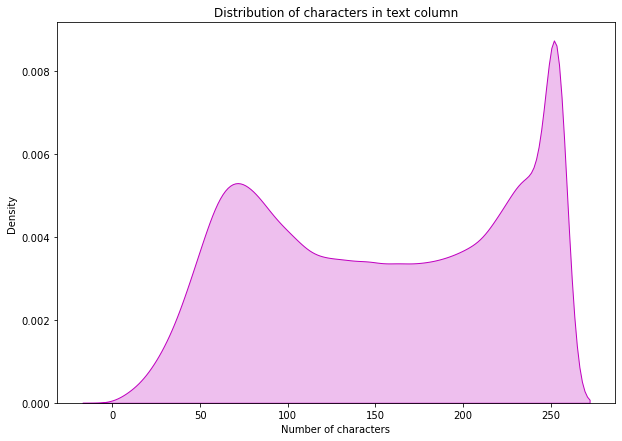

In [10]:
data["num of words in text"] = data["text"].apply(lambda x: len(x))
plt.figure(figsize=(10,7))
sns.kdeplot(data["num of words in text"],shade=True, color='m')
plt.title("Distribution of characters in text column")
plt.xlabel("Number of characters")
plt.show()

In [11]:
print('no. of unique users:', len(data['user_id'].unique()))

no. of unique users: 69021


In [12]:
# Clean text
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [13]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

In [14]:
# Remove emoji's
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['text']=data['text'].apply(lambda x: remove_emoji(x))

In [22]:
# Tokenize and lemmatize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return lemmatized_words

data['token_text'] = data.text.apply(lemmatize_text)

In [24]:
data.head()

,created_at_last,text,user_id,country,num of words in text,token_text
0,1/29/2020,a shanghai resident infected with coronavirusr...,1.220000e+18,ä¸­å½,194,"[a, shanghai, resident, infected, with, corona..."
1,1/29/2020,the coronavirus is a threat to the global drug...,1.378637e+09,United States,53,"[the, coronavirus, is, a, threat, to, the, glo..."
2,1/28/2020,unsettling it suggests a dangerous politicisat...,1.220000e+18,Australia,204,"[unsettling, it, suggests, a, dangerous, polit..."
3,1/31/2020,coronavirus overtakes sars via scmpgraphics ...,2.450444e+09,United States,65,"[coronavirus, overtakes, sars, via, scmpgraphi..."
4,1/25/2020,coronavirus more feedback from wuhan medical s...,1.220000e+18,Asia,249,"[coronavirus, more, feedback, from, wuhan, med..."


In [30]:
common = Counter(" ".join(map(str,data["token_text"])).split()).most_common(51)

In [31]:
common

[("'the',", 227029),
 ("'to',", 171459),
 ("'of',", 129243),
 ("'a',", 118468),
 ("'in',", 106957),
 ("'and',", 104366),
 ("'is',", 69971),
 ("'for',", 67815),
 ("'on',", 48482),
 ("'covid',", 47654),
 ("'coronavirus',", 46737),
 ("'are',", 42179),
 ("'it',", 38210),
 ("'that',", 36986),
 ("'with',", 36368),
 ("'from',", 34378),
 ("'this',", 33017),
 ("'have',", 32482),
 ("'you',", 30433),
 ("'be',", 28858),
 ("'ha',", 27594),
 ("'at',", 25701),
 ("'we',", 25661),
 ("'case',", 25158),
 ("'i',", 23260),
 ("'not',", 23035),
 ("'by',", 21537),
 ("'amp',", 21198),
 ("'will',", 21132),
 ("'people',", 20767),
 ("'about',", 18702),
 ("'our',", 17942),
 ("'more',", 17406),
 ("'all',", 17269),
 ("'new',", 16868),
 ("'who',", 16755),
 ("'but',", 16346),
 ("'they',", 15616),
 ("'u',", 15167),
 ("'wa',", 15072),
 ("'health',", 14913),
 ("'your',", 13827),
 ("'death',", 13684),
 ("'been',", 13630),
 ("'can',", 13454),
 ("'an',", 13144),
 ("'or',", 13043),
 ("'how',", 12934),
 ("'if',", 12685),
 ("[

In [33]:
data['tokens'] = data['token_text'].map(lambda tokens: ' '.join(tokens))


In [34]:
data['token_text2'] = data.tokens.apply(lemmatize_text)

In [39]:
list_common = ["the", "to", "of", "a", "in", "and", "is", "for", "on", "covid", "coronavirus", "are", "it", "that", "with", "from", "this", "have", "you", "be", "ha", "at", "we", "case", "i", "not", "by", "amp", "will", "people", "about", "our", "more", "all", "new", "who", "but", "they", "u", "wa", "health", "your", "death", "been", "can", "an", "or", "how", "if", "now"]

In [36]:
data['token_text3'] = data['token_text'].apply(lambda x: [item for item in x if item not in c])

In [40]:
data.head()

,created_at_last,text,user_id,country,num of words in text,token_text,tokens,token_text2,token_text3
0,1/29/2020,a shanghai resident infected with coronavirusr...,1.220000e+18,ä¸­å½,194,"[a, shanghai, resident, infected, with, corona...",a shanghai resident infected with coronavirusr...,"[a, shanghai, resident, infected, with, corona...","[a, shanghai, resident, infected, with, corona..."
1,1/29/2020,the coronavirus is a threat to the global drug...,1.378637e+09,United States,53,"[the, coronavirus, is, a, threat, to, the, glo...",the coronavirus is a threat to the global drug...,"[the, coronavirus, is, a, threat, to, the, glo...","[the, coronavirus, is, a, threat, to, the, glo..."
2,1/28/2020,unsettling it suggests a dangerous politicisat...,1.220000e+18,Australia,204,"[unsettling, it, suggests, a, dangerous, polit...",unsettling it suggests a dangerous politicisat...,"[unsettling, it, suggests, a, dangerous, polit...","[unsettling, it, suggests, a, dangerous, polit..."
3,1/31/2020,coronavirus overtakes sars via scmpgraphics ...,2.450444e+09,United States,65,"[coronavirus, overtakes, sars, via, scmpgraphi...",coronavirus overtakes sars via scmpgraphics da...,"[coronavirus, overtakes, sars, via, scmpgraphi...","[coronavirus, overtakes, sars, via, scmpgraphi..."
4,1/25/2020,coronavirus more feedback from wuhan medical s...,1.220000e+18,Asia,249,"[coronavirus, more, feedback, from, wuhan, med...",coronavirus more feedback from wuhan medical s...,"[coronavirus, more, feedback, from, wuhan, med...","[coronavirus, more, feedback, from, wuhan, med..."


In [41]:
# Load in pre-trained semantic vectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)
tweets_df = data['token_text3'].copy(deep=True)

In [42]:
tweets_df

0         [a, shanghai, resident, infected, with, corona...
1         [the, coronavirus, is, a, threat, to, the, glo...
2         [unsettling, it, suggests, a, dangerous, polit...
3         [coronavirus, overtakes, sars, via, scmpgraphi...
4         [coronavirus, more, feedback, from, wuhan, med...
                                ...                        
230894    [i, had, covid, in, june, amp, wa, so, sick, i...
230895    [argottv, zarthenix, adamcarolla, what, gall, ...
230896    [the, new, normal, will, be, fine, and, weâl...
230897    [âgrouse, shooting, ha, been, made, exempt, ...
230898    [how, covid, is, creating, new, fintech, billi...
Name: token_text3, Length: 230899, dtype: object

In [43]:
# Create word embeddings
def word_embedding(series, model_w2v):
    """ Word embedding vectorization of tweets. Return a series of the vectors. """

    tweet_list = series.tolist()
    # get number of features for vectors in model_w2v to use when creating arbitrary vector
    size = model_w2v.vector_size
    # for each word in a tweet find it's word embedding vector and append it to a list (of vectors)
    for i, tweet in enumerate(tweet_list):
        vec_list = []
        for j, word in enumerate(tweet):
            if word in model_w2v.wv.vocab:
                vec_list.append(model_w2v[word])
        if len(vec_list) == 0:
            vec_list.append(0)
        # convert vec_list to numpy array (an array of vectors)
        arr = np.array(vec_list)
        #print(arr)
        # change tweet_list item with mean vector
        tweet_list[i] = arr.mean(axis=0).tolist()

    ser = pd.Series(tweet_list)
    # return series of vectors for tweets
    return ser

In [44]:
# Create data frame with embeddings
tweets_embedded_df = word_embedding(tweets_df, model)
tweets_concat = pd.concat([tweets_df, tweets_embedded_df], axis=1)
tweets_concat.columns = ['token_text', 'vector_tweets']

<ipython-input-43-400bcf0d3cb3>:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in model_w2v.wv.vocab:


In [45]:
tweets_embedded_df

0         [-0.00352411693893373, 0.060077544301748276, 0...
1         [-0.08975601196289062, 0.03143310546875, 0.061...
2         [0.03186889737844467, 0.009546775370836258, 0....
3         [0.02119140699505806, 0.01806640625, -0.074414...
4         [0.0313371941447258, 0.03427933156490326, 0.00...
                                ...                        
230894    [0.0016645349096506834, 0.03144969046115875, 0...
230895    [0.06397686898708344, 0.03378758206963539, 0.0...
230896    [0.01021423377096653, 0.030449580401182175, 0....
230897    [0.04561714455485344, 0.01838655024766922, 0.0...
230898    [0.0227508544921875, 0.02996826171875, -0.0123...
Length: 230899, dtype: object

In [46]:
# Remove rows for which no words were present in the word2vec model
tweets_concat = tweets_concat[tweets_concat.vector_tweets != 0]

In [47]:
# Make list of emotions
emotions_list = [ 'good','bad','hope','panic','care', 'afraid']

In [48]:
# Retrieve embeddings for emotions
emotions= model[emotions_list]

In [49]:
# Create a dataframe with the embedding for each emotion
emotions_df= DataFrame(emotions, columns= ["dim" + str(d) for d in list(range(1,301))], 
  index = emotions_list)

In [50]:
emotions_df

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim291,dim292,dim293,dim294,dim295,dim296,dim297,dim298,dim299,dim300
good,0.040527,0.062500,-0.017456,0.078613,0.032715,-0.012634,0.009644,0.123535,-0.021484,0.152344,...,0.014221,0.187500,-0.165039,0.015381,-0.041748,0.054443,-0.011841,-0.156250,0.001930,-0.069824
bad,0.062988,0.124512,0.113281,0.073242,0.038818,0.079102,0.050781,0.171875,0.096191,0.220703,...,0.011353,0.341797,-0.090332,0.076660,-0.032471,0.133789,-0.154297,-0.063477,0.114746,0.031006
hope,0.016113,0.145508,0.222656,0.105469,-0.015015,-0.041504,0.335938,-0.148438,-0.014099,-0.039551,...,-0.081543,0.009399,0.031982,-0.218750,0.026733,0.047119,-0.174805,-0.089844,0.109863,-0.053467
panic,0.221680,-0.261719,-0.075195,0.101074,-0.300781,-0.071777,-0.253906,-0.060547,0.287109,-0.227539,...,0.031250,-0.324219,-0.025513,-0.092285,0.121094,0.112793,-0.367188,0.075684,0.042969,0.218750
care,-0.197266,0.250000,0.052246,0.029419,-0.012573,0.096680,0.359375,-0.175781,-0.088379,-0.115234,...,-0.108887,0.041016,-0.051514,-0.000912,-0.128906,0.187500,-0.127930,0.167969,0.048828,-0.088867
afraid,0.310547,0.066406,0.213867,0.062500,-0.186523,0.188477,0.324219,0.055176,0.263672,0.209961,...,-0.168945,0.083984,-0.110840,-0.037842,-0.186523,-0.186523,-0.105469,-0.014282,0.068848,-0.006134


In [51]:
# Go over the emotions. For each emotion, calculate the cosine similarity between 
# the embedding for that emotion and the embedding for each Tweet
for i in range(len(emotions_list)):
    # Determine the name of the emotion
    emotion = emotions_list[i]
    # Retrieve the embedding for the emotion
    vec_emotion = emotions_df.loc[emotion].values.tolist()
    # Initialize a list of cosine similarity values
    values = []
    # Loop over the Tweets
    for j in range(tweets_concat.shape[0]):
        # Retrieve the embedding for tweet j
        vec_tweet = tweets_concat.iat[j,1]
        # Calculate the cosine similarity of the embeddings for the current tweet and the 
        # current emotion
        values.append(1 - spatial.distance.cosine(vec_emotion, vec_tweet))
    # Create a new column that contains the cosine similarities for each Tweet for the 
    # current emotion
    tweets_concat[emotion] = values

In [52]:
# Ensure the results look sensible
print(tweets_concat.head())

                                          token_text  \
0  [a, shanghai, resident, infected, with, corona...   
1  [the, coronavirus, is, a, threat, to, the, glo...   
2  [unsettling, it, suggests, a, dangerous, polit...   
3  [coronavirus, overtakes, sars, via, scmpgraphi...   
4  [coronavirus, more, feedback, from, wuhan, med...   

                                       vector_tweets      good       bad  \
0  [-0.00352411693893373, 0.060077544301748276, 0...  0.240234  0.258841   
1  [-0.08975601196289062, 0.03143310546875, 0.061...  0.216499  0.203327   
2  [0.03186889737844467, 0.009546775370836258, 0....  0.373146  0.413821   
3  [0.02119140699505806, 0.01806640625, -0.074414...  0.184014  0.148505   
4  [0.0313371941447258, 0.03427933156490326, 0.00...  0.409996  0.381085   

       hope     panic      care    afraid  
0  0.233004  0.260150  0.359045  0.278170  
1  0.188947  0.228548  0.216795  0.139046  
2  0.347471  0.366628  0.194523  0.351020  
3  0.123270  0.179774  0.06729

In [53]:
df_full = pd.DataFrame(tweets_concat, columns =['token_text', 'vector_tweets', 'good', 'bad', 'hope', 'panic', 'care','afraid'])

In [55]:
df_full.head()

,token_text,vector_tweets,good,bad,hope,panic,care,afraid
0,"[a, shanghai, resident, infected, with, corona...","[-0.00352411693893373, 0.060077544301748276, 0...",0.240234,0.258841,0.233004,0.260150,0.359045,0.278170
1,"[the, coronavirus, is, a, threat, to, the, glo...","[-0.08975601196289062, 0.03143310546875, 0.061...",0.216499,0.203327,0.188947,0.228548,0.216795,0.139046
2,"[unsettling, it, suggests, a, dangerous, polit...","[0.03186889737844467, 0.009546775370836258, 0....",0.373146,0.413821,0.347471,0.366628,0.194523,0.351020
3,"[coronavirus, overtakes, sars, via, scmpgraphi...","[0.02119140699505806, 0.01806640625, -0.074414...",0.184014,0.148505,0.123270,0.179774,0.067299,0.036831
4,"[coronavirus, more, feedback, from, wuhan, med...","[0.0313371941447258, 0.03427933156490326, 0.00...",0.409996,0.381085,0.394953,0.311389,0.450762,0.366115


In [54]:
df_full.tail()

,token_text,vector_tweets,good,bad,hope,panic,care,afraid
230894,"[i, had, covid, in, june, amp, wa, so, sick, i...","[0.0016645349096506834, 0.03144969046115875, 0...",0.404086,0.397665,0.256196,0.260485,0.232005,0.330549
230895,"[argottv, zarthenix, adamcarolla, what, gall, ...","[0.06397686898708344, 0.03378758206963539, 0.0...",0.437104,0.424779,0.337420,0.279477,0.383000,0.411760
230896,"[the, new, normal, will, be, fine, and, weâl...","[0.01021423377096653, 0.030449580401182175, 0....",0.502849,0.415253,0.395595,0.184572,0.244312,0.342247
230897,"[âgrouse, shooting, ha, been, made, exempt, ...","[0.04561714455485344, 0.01838655024766922, 0.0...",0.381947,0.366450,0.376806,0.249760,0.260953,0.372222
230898,"[how, covid, is, creating, new, fintech, billi...","[0.0227508544921875, 0.02996826171875, -0.0123...",0.257743,0.194390,0.227500,0.104429,0.184390,0.204767


In [58]:
df_full['maxValuesObj'] = df_full.iloc[:, 2:].max(axis=1)

In [59]:
df_full[1425:1430]

,token_text,vector_tweets,good,bad,hope,panic,care,afraid,maxValuesObj
1425,"[road, in, wuhan, china, on, lockdown, and, bl...","[-0.07534535974264145, 0.03020223043859005, 0....",0.246705,0.231162,0.168090,0.276627,0.199964,0.196980,0.276627
1426,"[breaking, man, from, yunnan, china, who, wa, ...","[-0.0377197265625, 0.0729951336979866, 0.03768...",0.245070,0.256956,0.199549,0.202070,0.271561,0.235451,0.271561
1427,"[the, spread, of, the, coronavirus, ha, create...","[-0.0121002197265625, 0.06463438272476196, -0....",0.304992,0.250523,0.214728,0.173416,0.269212,0.197477,0.304992
1428,"[the, death, toll, from, a, coronavirus, outbr...","[0.002209133468568325, 0.04520951211452484, 0....",0.326370,0.314117,0.301933,0.276145,0.283021,0.259115,0.326370
1429,"[to, contain, disease, outbreak, health, offic...","[0.088623046875, -0.024993896484375, 0.0560455...",0.231113,0.236330,0.236860,0.305583,0.350724,0.219950,0.350724


In [60]:
df_temp = df_full.drop(columns = ['token_text','vector_tweets'])

In [61]:
df_temp

,good,bad,hope,panic,care,afraid,maxValuesObj
0,0.240234,0.258841,0.233004,0.260150,0.359045,0.278170,0.359045
1,0.216499,0.203327,0.188947,0.228548,0.216795,0.139046,0.228548
2,0.373146,0.413821,0.347471,0.366628,0.194523,0.351020,0.413821
3,0.184014,0.148505,0.123270,0.179774,0.067299,0.036831,0.184014
4,0.409996,0.381085,0.394953,0.311389,0.450762,0.366115,0.450762
...,...,...,...,...,...,...,...
230894,0.404086,0.397665,0.256196,0.260485,0.232005,0.330549,0.404086
230895,0.437104,0.424779,0.337420,0.279477,0.383000,0.411760,0.437104
230896,0.502849,0.415253,0.395595,0.184572,0.244312,0.342247,0.502849
230897,0.381947,0.366450,0.376806,0.249760,0.260953,0.372222,0.381947


In [62]:
 df_temp['Max'] = df_temp.idxmax(axis=1)

In [63]:
df_temp

,good,bad,hope,panic,care,afraid,maxValuesObj,Max
0,0.240234,0.258841,0.233004,0.260150,0.359045,0.278170,0.359045,care
1,0.216499,0.203327,0.188947,0.228548,0.216795,0.139046,0.228548,panic
2,0.373146,0.413821,0.347471,0.366628,0.194523,0.351020,0.413821,bad
3,0.184014,0.148505,0.123270,0.179774,0.067299,0.036831,0.184014,good
4,0.409996,0.381085,0.394953,0.311389,0.450762,0.366115,0.450762,care
...,...,...,...,...,...,...,...,...
230894,0.404086,0.397665,0.256196,0.260485,0.232005,0.330549,0.404086,good
230895,0.437104,0.424779,0.337420,0.279477,0.383000,0.411760,0.437104,good
230896,0.502849,0.415253,0.395595,0.184572,0.244312,0.342247,0.502849,good
230897,0.381947,0.366450,0.376806,0.249760,0.260953,0.372222,0.381947,good


In [64]:
df_temp2 = pd.concat([df_full['token_text'], df_temp], axis=1)

In [66]:
df_final = pd.concat([data, df_temp2], axis =1)

In [67]:
df_final.loc[1429]

created_at_last                                                 1/28/2020
text                    to contain disease outbreaks health officials ...
user_id                                                        82350646.0
country                                                          Portugal
num of words in text                                                   70
token_text              [to, contain, disease, outbreak, health, offic...
tokens                  to contain disease outbreak health official re...
token_text2             [to, contain, disease, outbreak, health, offic...
token_text3             [to, contain, disease, outbreak, health, offic...
token_text              [to, contain, disease, outbreak, health, offic...
good                                                             0.231113
bad                                                               0.23633
hope                                                              0.23686
panic                                 

In [68]:
df_final[1428:1430]

,created_at_last,text,user_id,country,num of words in text,token_text,tokens,token_text2,token_text3,token_text,good,bad,hope,panic,care,afraid,maxValuesObj,Max
1428,1/27/2020,the death toll from a coronavirus outbreak in ...,1.220000e+18,India,222,"[the, death, toll, from, a, coronavirus, outbr...",the death toll from a coronavirus outbreak in ...,"[the, death, toll, from, a, coronavirus, outbr...","[the, death, toll, from, a, coronavirus, outbr...","[the, death, toll, from, a, coronavirus, outbr...",0.326370,0.314117,0.301933,0.276145,0.283021,0.259115,0.326370,good
1429,1/28/2020,to contain disease outbreaks health officials ...,8.235065e+07,Portugal,70,"[to, contain, disease, outbreak, health, offic...",to contain disease outbreak health official re...,"[to, contain, disease, outbreak, health, offic...","[to, contain, disease, outbreak, health, offic...","[to, contain, disease, outbreak, health, offic...",0.231113,0.236330,0.236860,0.305583,0.350724,0.219950,0.350724,care


In [69]:
df_final.isna().sum()

created_at_last          0
text                     0
user_id                  0
country                  0
num of words in text     0
token_text               0
tokens                   0
token_text2              0
token_text3              0
token_text              71
good                    71
bad                     71
hope                    71
panic                   71
care                    71
afraid                  71
maxValuesObj            71
Max                     71
dtype: int64

In [70]:
df_final.dropna(inplace = True)

In [71]:
df_final.shape

(230828, 18)

In [72]:
df_final.drop_duplicates(subset='text', keep="first", inplace = True)

In [73]:
df_final = df_final.reset_index(drop=True)

In [74]:
df_final.shape

(229693, 18)

In [75]:
sentiment_counts = df_final.groupby(['Max']).count()


In [76]:
sentiment_counts

,created_at_last,text,user_id,country,num of words in text,token_text,tokens,token_text2,token_text3,token_text,good,bad,hope,panic,care,afraid,maxValuesObj
Max,,,,,,,,,,,,,,,,,
afraid,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084,40084
bad,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588,23588
care,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709,25709
good,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693,96693
hope,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791,32791
panic,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828,10828


In [77]:
popular_sentiments = df_final['Max'].value_counts()
print(popular_sentiments)

Max
good      96693
afraid    40084
hope      32791
care      25709
bad       23588
panic     10828
Name: count, dtype: int64


<AxesSubplot:ylabel='Max'>

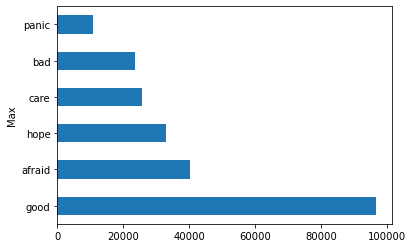

In [78]:
df_final['Max'].value_counts().plot(kind='barh')

In [79]:
print(df_final['Max'].value_counts(normalize=True))

Max
good      0.420966
afraid    0.174511
hope      0.142760
care      0.111928
bad       0.102694
panic     0.047141
Name: proportion, dtype: float64


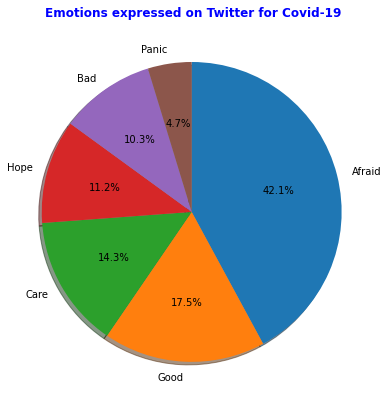

In [80]:
a = df_final['Max'].value_counts()[:10]
b= a.array
labels = [  'Afraid', 'Good', 'Care', 'Hope', 'Bad', 'Panic']


fig1, ax1 = plt.subplots(figsize=(6, 7),subplot_kw=dict(aspect="equal"))
ax1.pie(b, labels=labels, autopct='%1.1f%%', startangle = -270, counterclock=False, 
        shadow=True)
colors = ['b','#w','#99ff99','#ffcc99']
ax1.axis('equal')
plt.title("Emotions expressed on Twitter for Covid-19", weight = 'bold', size = 12, color = 'b')

plt.savefig("Covid-19_final_emotions.png")

plt.show()